In [1]:
import io

import pandas as pd
import numpy as np

from netam.framework import load_crepe
from dnsmex.local import localify
from dnsmex.dasm_viz import selection_df_from_factors, dms_style_heatmap

# AlphaSeq Dataset

Analyzing data from 

Engelhart, E., Emerson, R., Shing, L., Lennartz, C., Guion, D., Kelley, M., Lin, C., Lopez, R., Younger, D., & Walsh, M. E. (2022). _A dataset comprised of binding interactions for 104,972 antibodies against a SARS-CoV-2 peptide._ Scientific Data, 9(1), 653. https://doi.org/10.1038/s41597-022-01779-4

This requires that you download the data and put it in your `DATA_DIR` directory (see `local.py` for more details). The data can be downloaded from [Zenodo](https://zenodo.org/records/7783546/files/mit-ll/AlphaSeq_Antibody_Dataset-v2.0.0.zip?download=1).

Specifically, the following should be a valid path:

    DATA_DIR/alphaseq/antibody_dataset_1/

## Conclusion

This dataset has a lot of variants for the CDRs. A naive attempt to correlate the binding affinity in the CDRs with the DASM predictions did not work. OTOH this is not somewhere we should expect the DASM to work well, as of course it does not know the binding target.

Others for this sort of work do a regression on the final layer of the transformer, and I think that we should return to that once we have a paired model. 2/3 of the data is for light chains. It would be especially interesting to see if we can do higher-order predictions (there are a bunch of double and triple mutants).

In [2]:
# From table 1 of the paper. Note that "seed" in their lingo is the starting sequence that they mutate.

chain_info = """
Seed,Chain,Antibody
14,VH,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS
14,VL,DVVMTQSPESLAVSLGERATISCKSSQSVLYESRNKNSVAWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK
91,VH,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSGISWNSGSIGYADSVKGRFTISRDNAENSLYLQMNSLRAEDTALYYCAKVGRGGGYFDYWGQGTLVTVSS
91,VL,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPPQYLLRYKSDSDKQQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYCMIWHSSAWVFGGGTKLTVL
95,VH,EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARVGRGVIDHWGQGTLVTVSS
95,VL,SSELTQDPAVSVALGQTVRITCEGDSLRYYYANWYQQKPGQAPILVIYGKNNRPSGIADRFSGSNSGDTSSLIITGAQAEDEADYYCSSRDSSGFQVFFGAGTKLTVL
"""

chain_df = pd.read_csv(io.StringIO(chain_info), sep=",")

# sett Seed and Chain as index
chain_df = chain_df.set_index(["Seed", "Chain"])
chain_df.loc[91, "VH"]["Antibody"]

'EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSGISWNSGSIGYADSVKGRFTISRDNAENSLYLQMNSLRAEDTALYYCAKVGRGGGYFDYWGQGTLVTVSS'

In [3]:
# Concatenate together the VH and VL chains
# "The best chain orientation was selected for each antibody; HL was selected for Ab-14, LH was selected for Ab-91 and HL was selected for Ab-95."
seed_df = pd.DataFrame({
    "Seed": [14, 91, 95],
    "Antibody": [
        chain_df.loc[14, "VH"]["Antibody"] + chain_df.loc[14, "VL"]["Antibody"],
        chain_df.loc[91, "VL"]["Antibody"] + chain_df.loc[91, "VH"]["Antibody"],
        chain_df.loc[95, "VH"]["Antibody"] + chain_df.loc[95, "VL"]["Antibody"],
    ]
})

seed_df["length"] = seed_df["Antibody"].apply(len)
seed_df

,Seed,Antibody,length
0,14,EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPE...,231
1,91,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,234
2,95,EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...,225


In [4]:
asdf = pd.read_csv(localify("DATA_DIR/alphaseq/antibody_dataset_1/MITLL_AAlphaBio_Ab_Binding_dataset.csv"))
asdf["length"] = asdf['Sequence'].apply(len)
by_length = asdf.groupby("length")
by_length_dict = dict(list(by_length))
by_length_dict.keys()

dict_keys([240, 246, 249])

In [5]:
representatives = {length: df.reset_index(drop=True).loc[0,"Sequence"] for length, df in by_length}
representatives

{240: 'EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARVGRGVIDHWGQGTLVTVSSGGGGSGGGGSGGGGSSSELTQDPAVSVALGQTVRITCEGDSLRYYYANWYQQKPGQAPILVIYGKNNRPSGIADRFSGSNSGDTSSLIITGAQAEDEADYYCSSRDSSGFQVFFGAGTKLTVL',
 246: 'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSSGGGGSGGGGSGGGGSDVVMTQSPESLAVSLGERATISCHSSQSVGYESRMKNSVAWYQQKAGQPPKLLIYWASTRESGVPDRFSGSGSGTDFTLTISSLQAEDAAVYYCQQYHRLPLSFGGGTKVEIK',
 249: 'QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPPQYLLRYKSDSDKQQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYCMIWHSSAWVFGGGTKLTVLGGGGSGGGGSGGGGSEVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSGISWNSGSIGYADSVKGRFTISRDNAENSLYLQMNSLRAEDTALYYCAKVGRGGGYFDYWGQGTLVTVSS'}

In [6]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

# Dictionary to track the best alignment scores and seeds for each length
best_alignments = {}

for length, rep_seq in representatives.items():
    best_score = 0  # Initialize best score for this length
    best_seed = None
    best_alignment = None
    
    for index, row in seed_df.iterrows():
        # Perform the pairwise alignment
        alignments = pairwise2.align.globalxx(rep_seq, row['Antibody'])
        score = alignments[0][2]  # Take the score of the best alignment
        
        # Update the best score, seed, and alignment if this one is better
        if score > best_score:
            best_score = score
            best_seed = row["Seed"]
            best_alignment = alignments[0]
    
    # Store the best mapping for this length
    best_alignments[length] = (best_seed, best_score, best_alignment)

# Print the mapping and the best alignments
for length, (seed, score, alignment) in best_alignments.items():
    print(f"Length: {length}, Best Seed: {seed}, Best Score: {score}")
    print("Best Alignment:")
    print(format_alignment(*alignment))

/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Length: 240, Best Seed: 95, Best Score: 225.0
Best Alignment:
EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARVGRGVIDHWGQGTLVTVSSGGGGSGGGGSGGGGSSSELTQDPAVSVALGQTVRITCEGDSLRYYYANWYQQKPGQAPILVIYGKNNRPSGIADRFSGSNSGDTSSLIITGAQAEDEADYYCSSRDSSGFQVFFGAGTKLTVL
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||           |    |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
EVQLVESGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLEWMGWISAYNGNTNYAQKLQGRVTMTTDTSTSTAYMELRSLRSDDTAVYYCARVGRGVIDHWGQGTLVTV-----------S----SSSELTQDPAVSVALGQTVRITCEGDSLRYYYANWYQQKPGQAPILVIYGKNNRPSGIADRFSGSNSGDTSSLIITGAQAEDEADYYCSSRDSSGFQVFFGAGTKLTVL
  Score=225

Length: 246, Best Seed: 14, Best Score: 228.0
Best Alignment:
EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSSGGGGSGGGGSGGGGSDVVMTQS

This looks good.
As per the section _In silico design of antibody libraries_, 91 is the only library that has mutations in the heavy chain.

 Note that the first sequence of 91 appears to be unmutated.

In [7]:
by_seed_dict = {best_alignments[length][0]: by_length_dict[length] for length in by_length_dict}
by_seed_dict[91]

,POI,Sequence,Target,Assay,Replicate,Pred_affinity,HC,LC,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3,length
77690,MIT_91_LH_scFV,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg1,1,1,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYADSVK,VGRGGGYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
77691,MIT_91_LH_scFV,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg2,1,1,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYADSVK,VGRGGGYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
77692,MIT_91_LH_scFV,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg3,1,1,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYADSVK,VGRGGGYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
77693,MIT_91_LH_scFV,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,MIT_Target,1,1,1.184739,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYADSVK,VGRGGGYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
289952,MIT_91_LH_scFV,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg1,1,2,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYADSVK,VGRGGGYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259694,AAYL51_4283,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg1,2,3,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYAPSVK,VGRGGHYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
1259695,AAYL51_4283,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg2,2,3,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYAPSVK,VGRGGHYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
1259696,AAYL51_4283,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg3,2,3,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYAPSVK,VGRGGHYFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249
1259697,AAYL51_4284,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,AlphaNeg1,2,3,NaN,EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLE...,QAVLTQPSSLSASPGASVSLTCTLRSGINVGTYRIYWYQQKPGSPP...,GFTFDDYAMH,GISWNSGSIGYAGSVK,VGRGGGIFDY,TLRSGINVGTYRIY,YKSDSDKQQGSGV,MIWHSSAWV,249


In [8]:
def protein_differences(seq1, seq2):
    """
    Compare two protein sequences and express differences in a 1-indexed format like A105G.

    Args:
        seq1 (str): The first protein sequence.
        seq2 (str): The second protein sequence.

    Returns:
        list: A list of differences in the format A105G.
    """
    # Assert that the sequences are the same length
    assert len(seq1) == len(seq2), "Sequences must be of the same length"

    differences = []

    # Compare the sequences and record differences
    for i, (res1, res2) in enumerate(zip(seq1, seq2), start=1):
        if res1 != res2:
            differences.append(f"{res1}{i}{res2}")

    return differences

# Example usage
seq1 = "MKTAYIAKQRQISFVKSHFSRQDILDLWIYHTQGYFPAWQNY"
seq2 = "KKTAYIAKQRQISFVKSHFSRQDILDLWIYHTQGYFPDWQNY"
differences = protein_differences(seq1, seq2)
print(differences)

['M1K', 'A38D']


Build a mutagenesis data frame.

**NOTE: we are dropping all negative control measurements. This appears to be standard practice for these data. The alternative would be to drop sequences that appear to have promiscuous binding.**

In [9]:
mutagenesis_df = by_seed_dict[91].copy().reset_index(drop=True)
reference_seq = mutagenesis_df.loc[0, "Sequence"]

control_df = mutagenesis_df[mutagenesis_df["Target"].str.startswith("AlphaNeg")]
# limit control_df to the rows where Pred_affinity is not nan
control_df = control_df[~control_df["Pred_affinity"].isna()]
print("Summary of the binding affinities of the control antibodies:")
control_df["Pred_affinity"].describe()

Summary of the binding affinities of the control antibodies:


count    42755.000000
mean         4.543740
std          0.787385
min          1.098087
25%          4.023349
50%          4.536991
75%          5.069090
max          7.318652
Name: Pred_affinity, dtype: float64

difference_count
3    56460
2     9393
1     1563
0        9
Name: count, dtype: int64

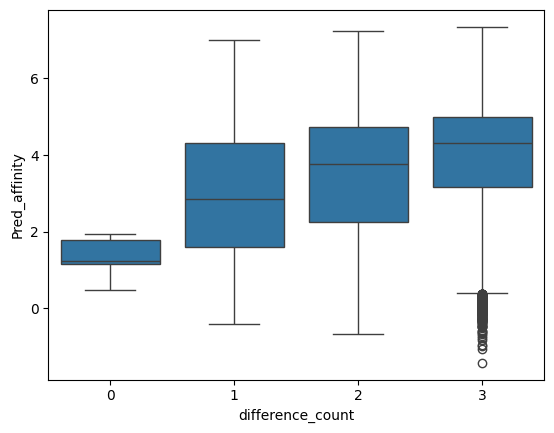

In [10]:
reference_seq = mutagenesis_df.loc[0, "Sequence"]

# Drop all rows where Target starts with AlphaNeg
mutagenesis_df = mutagenesis_df[~mutagenesis_df["Target"].str.startswith("AlphaNeg")]

assert (mutagenesis_df['Target'] == "MIT_Target").all()
mutagenesis_df = mutagenesis_df.drop(columns=["Target"])

# Calculate the differences between the reference and each sequence
mutagenesis_df["differences"] = mutagenesis_df["Sequence"].apply(lambda seq: protein_differences(reference_seq, seq))
mutagenesis_df["difference_count"] = mutagenesis_df["differences"].apply(len)

import seaborn as sns
import matplotlib.pyplot as plt
# Make a boxplot of the Pred_affinity values for each number of differences
sns.boxplot(x="difference_count", y="Pred_affinity", data=mutagenesis_df)

mutagenesis_df["difference_count"].value_counts()


In [11]:
wt_affinity_measurements = mutagenesis_df[mutagenesis_df["difference_count"]==0]["Pred_affinity"].values
print(f"WT affinity measurements: {wt_affinity_measurements}")
wt_affinity_mean = np.mean(wt_affinity_measurements)

WT affinity measurements: [1.18473883 1.23761341 1.25939777 1.78261234 1.02043754 1.9403826
 1.1460453  1.84211379 0.46312264]


In [12]:
single_mutants = mutagenesis_df[mutagenesis_df["difference_count"] == 1].copy()
single_mutants["difference"] = single_mutants["differences"].apply(lambda x: x[0])
single_mutants["site"] = single_mutants["difference"].apply(lambda x: int(x[1:-1]))
single_mutants["aa"] = single_mutants["difference"].apply(lambda x: x[-1])
single_mutants = single_mutants.groupby(["site", "aa"]).agg({"Pred_affinity": "mean"})
single_mutants.reset_index(inplace=True)
single_mutants

,site,aa,Pred_affinity
0,156,A,4.355426
1,156,C,1.678293
2,156,D,4.939398
3,156,E,NaN
4,156,H,2.654250
...,...,...,...
516,238,N,3.167030
517,238,Q,5.056431
518,238,S,0.220223
519,238,T,0.621245


59.03% are measured


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_84477/3954284949.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dms_style_df = dms_style_df.applymap(np.exp)


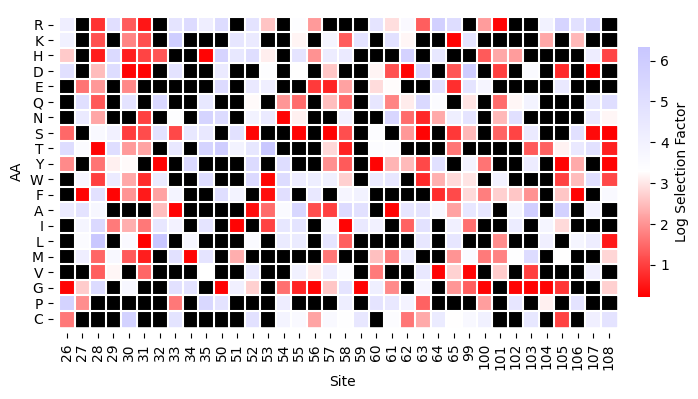

In [13]:
dms_style_df = single_mutants.pivot(index='aa', columns='site', values='Pred_affinity')

# exponentiate because plotting expects data in linear space
dms_style_df = dms_style_df.applymap(np.exp)

linker_for_91 = "GGGGSGGGGSGGGGS"
heavy_start = len(chain_df.loc[91, "VL"]["Antibody"]) + len(linker_for_91)
assert reference_seq[heavy_start:] == chain_df.loc[91, "VH"]["Antibody"], "heavy_start is not the index of the first amino acid in the heavy chain."

# Subtract so that index 0 is the first amino acid in the heavy chain.
dms_style_df.columns = dms_style_df.columns - heavy_start

vh_91 = chain_df.loc[91, "VH"]["Antibody"]
vh_91_entries = [vh_91[i-1] for i in dms_style_df.columns]

# Assert that all of the entries in dms_style_df are nan for the vh_91_entries. These should be nan because they are the reference sequence and we are subsetting to single mutants. We fill them in with WT.
for i, entry in enumerate(vh_91_entries):
    column = dms_style_df.columns[i]
    assert np.isnan(dms_style_df.loc[entry, column]), f"Entry {entry}{i+1} is not nan"
    dms_style_df.loc[entry, column] = wt_affinity_mean


print(f"{np.count_nonzero(~np.isnan(dms_style_df.values)) / dms_style_df.size:.2%} are measured")

_ = dms_style_heatmap(dms_style_df, cb_min_center_max=None)

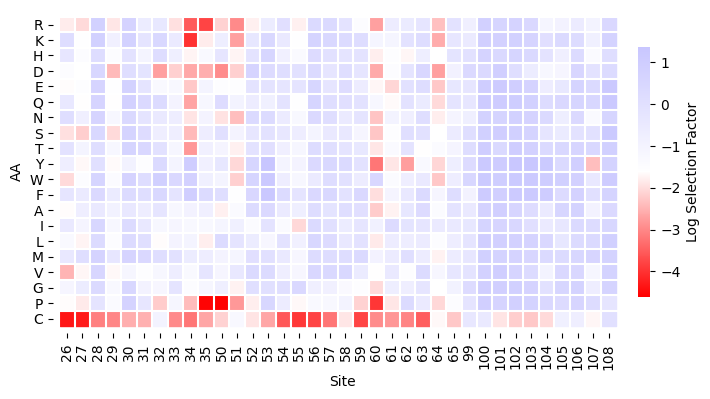

In [14]:
crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_1m-v1wyatt+v1tang-joint"))

[dasm_output] = crepe([vh_91])
dasm_selection_df = selection_df_from_factors(dasm_output)

subset_dasm_selection_df = dasm_selection_df[dms_style_df.columns]

_ = dms_style_heatmap(subset_dasm_selection_df, cb_min_center_max=None)